In [106]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [107]:
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [108]:
from trainlib.ConfigFileHandler import ConfigFileHandler
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler

In [124]:
campaign_dir="/data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/"

In [125]:
statistics_dir = campaign_dir + "statistics/"
if not os.path.exists(statistics_dir):
    os.makedirs(statistics_dir)

In [126]:
# for the full category set
bin_dir = {"Untagged": 0,
            "VBF1j": 1,
            "VBF2j": 2,
            "VHlept": 3,
            "VHhadr": 4,
            "ttHlept": 5,
            "ttHhadr": 6,
            "VHMET": 7}

In [127]:
def format_parameter_list(inlist):
    outstring = ""
    linewidth = 0
    
    for parameter in inlist:
        if "D_" in parameter:
            newstring = "MELA, "
        else:
            newstring = parameter + ", "
            
        outstring += newstring
        linewidth += len(newstring)
        
        if linewidth > 20:
            outstring += "\n"
            linewidth = 0
            
    return outstring[:-2]

In [128]:
df = pd.DataFrame()

for subdir in next(os.walk(campaign_dir))[1]:
    if "statistics" not in subdir and "bin" not in subdir:
        values = {}

        punzi_path = campaign_dir + subdir + "/comp/Mor18_punzi_comp.conf"
        settings_path = campaign_dir + subdir + "/settings.conf"
    
        try:
            # first, read back the configuration file for this run
            conf = ModelCollectionConfigFileHandler()
            conf.load_configuration(settings_path)
    
            # now select a typical model and read its hyperparameters
            typical_model = conf._get_model_list(conf._get_model_collection_list()[0])[0]
            hyperparams = conf.GetHyperparameters(typical_model)
            hyperparam_dict = {key: [val] for key, val in hyperparams.iteritems()}
        
            # also read the list of input parameters that have been fed into the network
            param_list = conf.GetInputParameterList(typical_model)
            values['input_columns'] = [format_parameter_list(param_list)]
            values['number_inputs'] = len(param_list)
            
            # then read in the results in terms of relative Punzi improvement for each category
            conf = ConfigFileHandler()
            conf.load_configuration(punzi_path)
        
            # load the Punzi values for each category
            for category, bin_number in bin_dir.iteritems():
                values[category] = float(conf.get_field("Punzi", category))
                    
            # merge the two dictionaries
            values.update(hyperparam_dict)
            df = df.append(pd.DataFrame.from_dict(values))
                
        except KeyError:
            print "File not found"

attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_1/settings.conf
attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_1/comp/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_2/settings.conf
attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_2/comp/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_3/settings.conf
attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_3/comp/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180401_input_parameter_sweep_full_category_set/input_columns_4/se

In [129]:
punzi_data = df[bin_dir.keys()].as_matrix()
punzi_data = np.transpose(punzi_data)

In [130]:
inparam_labels = df['input_columns'].as_matrix()

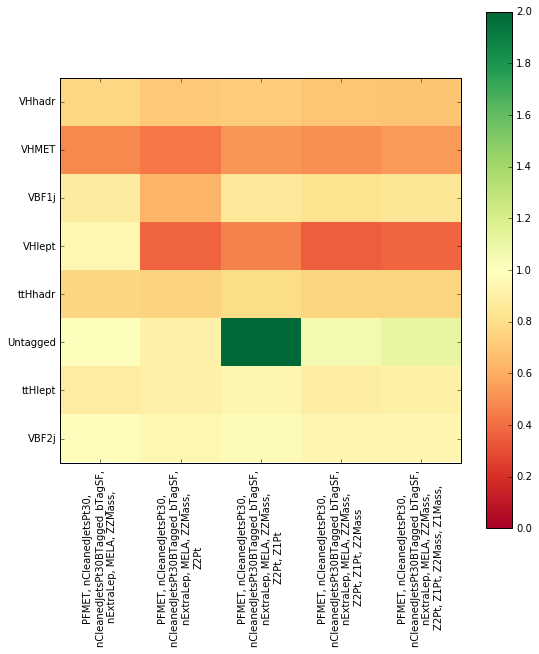

In [131]:
plt.figure(figsize = (8, 9))
plt.imshow(punzi_data, interpolation = 'none', cmap = 'RdYlGn', aspect = 0.6, vmin = 0.0, vmax = 2.0)
plt.colorbar()
plt.yticks(range(len(bin_dir)), bin_dir.keys())
plt.xticks(range(len(df)), inparam_labels, rotation = 'vertical')
plt.tight_layout()
#plt.savefig(statistics_dir + "punzi_input_sweep.pdf")
plt.show()